In [1]:
# single route
# HERE WE START WITH THE BASIC DATASET, WE ARE ONLY USING TIMESTAMP TO PREDICT
route = 'M15'
import pandas as pd
import numpy as np
df = pd.read_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}_cleaned.parquet')
df.shape

(161072, 14)

In [2]:
# disable GPU for small models
def gpu_off():
    import tensorflow as tf
    print(tf.config.get_visible_devices())

    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

    print(tf.config.get_visible_devices())

In [3]:
# if use GPU, incrase batch size
# batchsize = 2 ; gpu_off()
batchsize = 128

# ARIMA features

In [4]:
df = df.set_index('timestamp')
df = df[['passenger_count']]
df

,passenger_count
timestamp,
2021-05-02 20:52:34,12.0
2021-05-02 20:52:34,6.0
2021-05-02 20:53:35,12.0
2021-05-02 20:53:35,6.0
2021-05-02 20:54:35,8.0
...,...
2021-07-01 01:07:33,6.0
2021-07-01 01:08:33,5.0
2021-07-01 01:09:35,5.0


In [5]:
from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std

from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [6]:
# build features

features_request = {
    "window": [60], # should = 1 hour
    "window_statistic": [60, mean], 
    "difference_statistic": [60, 1, std], 
}

build_df = build_features(df.passenger_count, features_request, target_lag=10, include_tzero=True)

In [7]:
build_df.columns

Index(['T-60', 'T-59', 'T-58', 'T-57', 'T-56', 'T-55', 'T-54', 'T-53', 'T-52',
       'T-51', 'T-50', 'T-49', 'T-48', 'T-47', 'T-46', 'T-45', 'T-44', 'T-43',
       'T-42', 'T-41', 'T-40', 'T-39', 'T-38', 'T-37', 'T-36', 'T-35', 'T-34',
       'T-33', 'T-32', 'T-31', 'T-30', 'T-29', 'T-28', 'T-27', 'T-26', 'T-25',
       'T-24', 'T-23', 'T-22', 'T-21', 'T-20', 'T-19', 'T-18', 'T-17', 'T-16',
       'T-15', 'T-14', 'T-13', 'T-12', 'T-11', 'T-10', 'T-9', 'T-8', 'T-7',
       'T-6', 'T-5', 'T-4', 'T-3', 'T-2', 'T-1', 'window_statistic_60_mean',
       'difference_statistic_60_1_std', 'tzero', 'Target_Tplus10'],
      dtype='object')

In [8]:
build_df

,T-60,T-59,T-58,T-57,T-56,T-55,T-54,T-53,T-52,T-51,...,T-6,T-5,T-4,T-3,T-2,T-1,window_statistic_60_mean,difference_statistic_60_1_std,tzero,Target_Tplus10
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-02 21:55:07,12.0,6.0,12.0,6.0,8.0,16.0,16.0,6.0,6.0,20.0,...,0.0,6.0,8.0,7.0,7.0,10.0,10.816667,7.723757,10.0,7.0
2021-05-02 21:56:07,6.0,12.0,6.0,8.0,16.0,16.0,6.0,6.0,20.0,20.0,...,6.0,8.0,7.0,7.0,10.0,10.0,10.783333,7.685389,9.0,7.0
2021-05-02 21:57:08,12.0,6.0,8.0,16.0,16.0,6.0,6.0,20.0,20.0,5.0,...,8.0,7.0,7.0,10.0,10.0,9.0,10.833333,7.645590,9.0,7.0
2021-05-02 21:58:07,6.0,8.0,16.0,16.0,6.0,6.0,20.0,20.0,5.0,5.0,...,7.0,7.0,10.0,10.0,9.0,9.0,10.783333,7.641305,9.0,7.0
2021-05-02 21:59:07,8.0,16.0,16.0,6.0,6.0,20.0,20.0,5.0,5.0,20.0,...,7.0,10.0,10.0,9.0,9.0,9.0,10.833333,7.572953,7.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 00:57:22,0.0,12.0,0.0,0.0,2.0,12.0,0.0,12.0,0.0,2.0,...,3.0,5.0,5.0,6.0,7.0,6.0,5.316667,6.399916,7.0,6.0
2021-07-01 00:58:24,12.0,0.0,0.0,2.0,12.0,0.0,12.0,0.0,2.0,3.0,...,5.0,5.0,6.0,7.0,6.0,7.0,5.433333,6.205751,7.0,5.0
2021-07-01 00:59:24,0.0,0.0,2.0,12.0,0.0,12.0,0.0,2.0,3.0,0.0,...,5.0,6.0,7.0,6.0,7.0,7.0,5.350000,6.205751,7.0,5.0


In [9]:
df

,passenger_count
timestamp,
2021-05-02 20:52:34,12.0
2021-05-02 20:52:34,6.0
2021-05-02 20:53:35,12.0
2021-05-02 20:53:35,6.0
2021-05-02 20:54:35,8.0
...,...
2021-07-01 01:07:33,6.0
2021-07-01 01:08:33,5.0
2021-07-01 01:09:35,5.0


In [10]:
from sklearn.model_selection import train_test_split

# split
X = df[df.columns.values[:-1]]
y = np.array(df[df.columns.values[-1]]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(112750, 0) (48322, 0) (112750, 1) (48322, 1)


In [12]:
scaler_features = StandardScaler().fit(build_df[build_df.columns.values[:-1]])
scaled_features = scaler_features.transform(build_df[build_df.columns.values[:-1]])

scaler_label = StandardScaler().fit(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))
scaled_label = scaler_label.transform(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))


### Split data using train proportion of 0.7
train_size = int(scaled_features[:, :-1].shape[0] * 0.7)

X_train, y_train = scaled_features[:train_size, :-1], scaled_label[:train_size, :]
X_test, y_test = scaled_features[train_size:, :-1], scaled_label[train_size:, :]

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, verbose=1)

Metal device set to: Apple M1
Epoch 1/100


2022-01-05 00:08:12.769351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 00:08:12.770278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-05 00:08:12.933442: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-05 00:08:13.121710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3522/3522 [==============================] - 15s 4ms/step - loss: 0.6926
Epoch 2/100
3522/3522 [==============================] - 15s 4ms/step - loss: 0.6797
Epoch 3/100
3522/3522 [==============================] - 15s 4ms/step - loss: 0.6749
Epoch 4/100
3522/3522 [==============================] - 15s 4ms/step - loss: 0.6707
Epoch 5/100
3522/3522 [==============================] - 15s 4ms/step - loss: 0.6684
Epoch 6/100
3522/3522 [==============================] - 14s 4ms/step - loss: 0.6648
Epoch 7/100
3522/3522 [==============================] - 16s 4ms/step - loss: 0.6617
Epoch 8/100
3522/3522 [==============================] - 17s 5ms/step - loss: 0.6594
Epoch 9/100
3522/3522 [==============================] - 16s 5ms/step - loss: 0.6570
Epoch 10/100
3522/3522 [==============================] - 16s 5ms/step - loss: 0.6539
Epoch 11/100
3522/3522 [==============================] - 17s 5ms/step - loss: 0.6502
Epoch 12/100
3522/3522 [==============================] - 17s 5ms/step - lo

KeyError: 'val_loss'

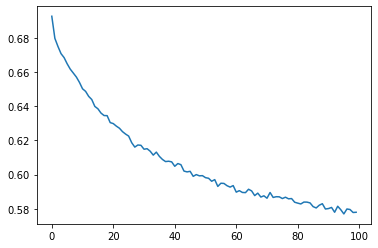

In [16]:
import matplotlib.pyplot as plt
# # evaluate
# # summarize history for accuracy
# plt.plot(history.history['mae'])
# plt.plot(history.history['val_mae'])
# plt.title('model mae')
# plt.ylabel('mae')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from tsextract.plots.eval import actualPred, get_lag_corr, scatter

actualPred(y_test.reshape(-1, ), test_pred.reshape(-1))
scatter(y_test.reshape(-1, ), test_pred.reshape(-1))
get_lag_corr(y_test.reshape(-1, ), test_pred.reshape(-1), num_lags=20)

NameError: name 'test_pred' is not defined

In [ ]:
# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping()

early_stopping = EarlyStopping(
    monitor='val_mae', 
    patience=8, 
    min_delta=0.01, 
    mode='auto'
)